# Comparación de Modelos ResNet18 V2: Con y Sin BatchNorm/Dropout

Este notebook implementa y compara dos variantes de ResNet18 con arquitectura tipo embudo según los requisitos de la **Versión 2: Clasificador extendido tipo embudo**:

- **V2 SIN BatchNorm y SIN Dropout**: Solo capas Linear + ReLU
- **V2 CON BatchNorm y CON Dropout**: Con BatchNorm antes de ReLU y Dropout entre capas

**Arquitectura tipo embudo**: 512 → 256 → 128 → num_classes

**Objetivos:**
- Evaluar el impacto de BatchNorm y Dropout en el rendimiento
- Comparar estabilidad de entrenamiento y capacidad de generalización
- Analizar curvas de pérdida y métricas de evaluación

In [1]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report

# Importar funciones de utilidad
from utils.data_proccess import create_dataloaders,create_transforms,load_datasets
from utils.train_model import train_model, plot_training_metrics
from utils.evaluate_model import evaluate_model
from utils.predict_images import predict_single_image

print("Librerías importadas exitosamente")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Librerías importadas exitosamente
PyTorch version: 2.9.1+cu128
CUDA available: True


In [2]:
# Load and Prepare Data
print("Cargando y preparando datos...")

# Configuración de datos
data_dir = 'datos'  # Ajustar según tu estructura
batch_size = 32
image_size = 224

# Crear transforms usando la función de utilidad
train_transform, val_test_transform = create_transforms(img_size=image_size)

# Cargar datasets
train_dataset, val_dataset, test_dataset = load_datasets(data_dir, train_transform, val_test_transform)

# Crear dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=batch_size
)

# Obtener nombres de clases
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")
print(f"Clases: {class_names}")
print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del dataset de validación: {len(val_dataset)}")
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")

Cargando y preparando datos...
Número de clases: 5
Clases: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Tamaño del dataset de entrenamiento: 438
Tamaño del dataset de validación: 47
Tamaño del dataset de prueba: 50


## Definición de Arquitectura V2 (Sin BatchNorm y Sin Dropout)

**Características del modelo:**
- Arquitectura tipo embudo con 3 capas ocultas: 512 → 256 → 128 → num_classes
- Solo capas Linear con activación ReLU
- **Sin BatchNormalization**
- **Sin Dropout**
- Backbone: ResNet18 preentrenado (features congeladas)
- Transfer Learning: Solo entrenar el clasificador personalizado

In [3]:
class ResNet18V2_Sin(nn.Module):
    """
    ResNet18 V2 SIN BatchNorm y SIN Dropout
    Arquitectura tipo embudo: 512 → 256 → 128 → num_classes
    Solo Linear + ReLU
    """
    def __init__(self, num_classes):
        super(ResNet18V2_Sin, self).__init__()
        
        # Cargar ResNet18 preentrenado
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Congelar las capas del feature extractor
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Obtener el número de features del último layer
        num_features = self.resnet.fc.in_features
        
        # Reemplazar el clasificador con arquitectura tipo embudo
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)

# Crear el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2_sin = ResNet18V2_Sin(num_classes).to(device)

print("Modelo V2 SIN BatchNorm/Dropout creado:")
print(f"Dispositivo: {device}")
print(f"Arquitectura del clasificador:")
print(model_v2_sin.resnet.fc)

Modelo V2 SIN BatchNorm/Dropout creado:
Dispositivo: cuda
Arquitectura del clasificador:
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=128, out_features=5, bias=True)
)


## Definición de Arquitectura V2 (Con BatchNorm y Con Dropout)

**Características del modelo:**
- Misma arquitectura tipo embudo: 512 → 256 → 128 → num_classes
- **BatchNorm1d antes de cada ReLU** en capas ocultas
- **Dropout (rate=0.3)** después de cada ReLU en capas ocultas
- Activación ReLU en todas las capas ocultas
- Backbone: ResNet18 preentrenado (features congeladas)
- **Técnicas de regularización aplicadas** para prevenir overfitting

In [4]:
class ResNet18V2_Con(nn.Module):
    """
    ResNet18 V2 CON BatchNorm y CON Dropout
    Arquitectura tipo embudo: 512 → 256 → 128 → num_classes
    BatchNorm antes de ReLU, Dropout entre capas
    """
    def __init__(self, num_classes, dropout_rate=0.3):
        super(ResNet18V2_Con, self).__init__()
        
        # Cargar ResNet18 preentrenado
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Congelar las capas del feature extractor
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Obtener el número de features del último layer
        num_features = self.resnet.fc.in_features
        
        # Reemplazar el clasificador con arquitectura tipo embudo + BN + Dropout
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)

# Crear el modelo
model_v2_con = ResNet18V2_Con(num_classes, dropout_rate=0.3).to(device)

print("Modelo V2 CON BatchNorm/Dropout creado:")
print(f"Dispositivo: {device}")
print(f"Arquitectura del clasificador:")
print(model_v2_con.resnet.fc)

Modelo V2 CON BatchNorm/Dropout creado:
Dispositivo: cuda
Arquitectura del clasificador:
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=128, out_features=5, bias=True)
)


## Configuración de Entrenamiento

**Parámetros comunes para ambos modelos:**
- **Criterion**: CrossEntropyLoss
- **Optimizer**: Adam (lr=0.001)
- **Early stopping**: patience=5 épocas
- **Épocas máximas**: 50
- **Batch size**: 32

**Métricas a registrar:**
- Pérdidas de entrenamiento y validación
- Accuracy de entrenamiento y validación
- Época de mejor rendimiento (best_epoch)

In [5]:
# Training Setup and Configuration

# Configuración del entrenamiento
learning_rate = 0.001
num_epochs = 50
patience = 5

# Criterion (reutilizado para ambos modelos)
criterion = nn.CrossEntropyLoss()

# Optimizadores para cada modelo
optimizer_v2_sin = optim.Adam(model_v2_sin.parameters(), lr=learning_rate)
optimizer_v2_con = optim.Adam(model_v2_con.parameters(), lr=learning_rate)

# Inicializar listas para tracking de pérdidas
train_losses_v2_sin = []
val_losses_v2_sin = []
train_losses_v2_con = []
val_losses_v2_con = []

print("Configuración de entrenamiento:")
print(f"Learning rate: {learning_rate}")
print(f"Número máximo de épocas: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Criterion: {criterion}")
print(f"Optimizadores creados para ambos modelos")

Configuración de entrenamiento:
Learning rate: 0.001
Número máximo de épocas: 50
Early stopping patience: 5
Criterion: CrossEntropyLoss()
Optimizadores creados para ambos modelos


## Entrenamiento Modelo V2 - Sin Regularización

**Modelo a entrenar:** ResNet18V2_Sin
- Arquitectura: Solo Linear + ReLU
- Sin BatchNorm, Sin Dropout
- Objetivo: Establecer baseline de rendimiento sin regularización

**Hipótesis:** Este modelo puede ser más propenso al overfitting pero podría converger más rápido inicialmente.

In [6]:
print("=" * 60)
print("ENTRENANDO MODELO V2 SIN BatchNorm/Dropout")
print("=" * 60)

# Entrenar el modelo usando la función de utilidad
model_v2_sin, train_losses_v2_sin, val_losses_v2_sin, train_accuracies_v2_sin, val_accuracies_v2_sin, best_epoch_v2_sin = train_model(
    model=model_v2_sin,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v2_sin,
    num_epochs=num_epochs,
    device=device,
    patience=patience
)

print(f"\nEntrenamiento completado!")
print(f"Total de épocas: {len(train_losses_v2_sin)}")
print(f"Mejor época: {best_epoch_v2_sin}")
print(f"Pérdida de entrenamiento final: {train_losses_v2_sin[-1]:.4f}")
print(f"Pérdida de validación final: {val_losses_v2_sin[-1]:.4f}")
print(f"Accuracy de entrenamiento final: {train_accuracies_v2_sin[-1]:.2f}%")
print(f"Accuracy de validación final: {val_accuracies_v2_sin[-1]:.2f}%")

ENTRENANDO MODELO V2 SIN BatchNorm/Dropout
Iniciando entrenamiento...
Device: cuda
Epochs maximos: 50
Early stopping patience: 5
------------------------------------------------------------
Epoch 1/50 - Batch 10/14 - Loss: 1.2471 - Acc: 39.38%
Epoch 1/50 completado en 9.28s
Train - Loss: 1.3379, Acc: 45.43%
Val   - Loss: 0.6035, Acc: 91.49%
Nuevo mejor modelo Val Loss: 0.6035, Val Acc: 91.49%
------------------------------------------------------------
Epoch 2/50 - Batch 10/14 - Loss: 0.4609 - Acc: 64.69%
Epoch 2/50 completado en 9.16s
Train - Loss: 0.8924, Acc: 65.30%
Val   - Loss: 0.5751, Acc: 74.47%
Nuevo mejor modelo Val Loss: 0.5751, Val Acc: 74.47%
------------------------------------------------------------
Epoch 3/50 - Batch 10/14 - Loss: 0.3226 - Acc: 80.62%
Epoch 3/50 completado en 9.08s
Train - Loss: 0.4706, Acc: 83.56%
Val   - Loss: 0.1552, Acc: 97.87%
Nuevo mejor modelo Val Loss: 0.1552, Val Acc: 97.87%
------------------------------------------------------------
Epoch 4/5

## Entrenamiento Modelo V2 - Con Regularización

**Modelo a entrenar:** ResNet18V2_Con
- Arquitectura: Linear + BatchNorm + ReLU + Dropout
- Con BatchNorm y Dropout (rate=0.3)
- Objetivo: Evaluar beneficios de las técnicas de regularización

**Hipótesis:** Este modelo debería tener mejor generalización y menor overfitting, posiblemente a costa de convergencia más lenta.

In [7]:
# Train Model V2 With BatchNorm/Dropout
print("=" * 60)
print("ENTRENANDO MODELO V2 CON BatchNorm/Dropout")  # Corregido el título
print("=" * 60)

# Entrenar el modelo usando la función de utilidad
model_v2_con, train_losses_v2_con, val_losses_v2_con, train_accuracies_v2_con, val_accuracies_v2_con, best_epoch_v2_con = train_model(
    model=model_v2_con,  # Corregido: usar model_v2_con
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v2_con,  # Corregido: usar optimizer_v2_con
    num_epochs=num_epochs,
    device=device,
    patience=patience
)

print(f"\nEntrenamiento completado!")
print(f"Total de épocas: {len(train_losses_v2_con)}")  # Corregido: usar variables _con
print(f"Mejor época: {best_epoch_v2_con}")
print(f"Pérdida de entrenamiento final: {train_losses_v2_con[-1]:.4f}")
print(f"Pérdida de validación final: {val_losses_v2_con[-1]:.4f}")
print(f"Accuracy de entrenamiento final: {train_accuracies_v2_con[-1]:.2f}%")
print(f"Accuracy de validación final: {val_accuracies_v2_con[-1]:.2f}%")

ENTRENANDO MODELO V2 CON BatchNorm/Dropout
Iniciando entrenamiento...
Device: cuda
Epochs maximos: 50
Early stopping patience: 5
------------------------------------------------------------
Epoch 1/50 - Batch 10/14 - Loss: 1.1076 - Acc: 51.25%
Epoch 1/50 completado en 8.97s
Train - Loss: 1.1710, Acc: 56.85%
Val   - Loss: 0.7335, Acc: 95.74%
Nuevo mejor modelo Val Loss: 0.7335, Val Acc: 95.74%
------------------------------------------------------------
Epoch 2/50 - Batch 10/14 - Loss: 0.5595 - Acc: 86.25%
Epoch 2/50 completado en 8.85s
Train - Loss: 0.5986, Acc: 87.67%
Val   - Loss: 0.2751, Acc: 95.74%
Nuevo mejor modelo Val Loss: 0.2751, Val Acc: 95.74%
------------------------------------------------------------
Epoch 3/50 - Batch 10/14 - Loss: 0.4309 - Acc: 91.56%
Epoch 3/50 completado en 8.83s
Train - Loss: 0.3936, Acc: 91.32%
Val   - Loss: 0.1770, Acc: 97.87%
Nuevo mejor modelo Val Loss: 0.1770, Val Acc: 97.87%
------------------------------------------------------------
Epoch 4/5

## Evaluación Modelo V2 - Sin BatchNorm/Dropout

**Evaluación en conjunto de prueba:**
- **Dataset**: Test set (datos no vistos durante entrenamiento)
- **Métricas**: Accuracy, Precision, Recall por clase
- **Visualizaciones**: Matriz de confusión con heatmap
- **Análisis**: Classification report detallado

**Objetivo:** Medir el rendimiento real del modelo sin regularización.

EVALUACIÓN MODELO V2 SIN BatchNorm/Dropout
Evaluando modelo en conjunto de test...

Resultados de evaluacion:
Accuracy total: 0.9800 (98.00%)
Muestras correctas: 49/50


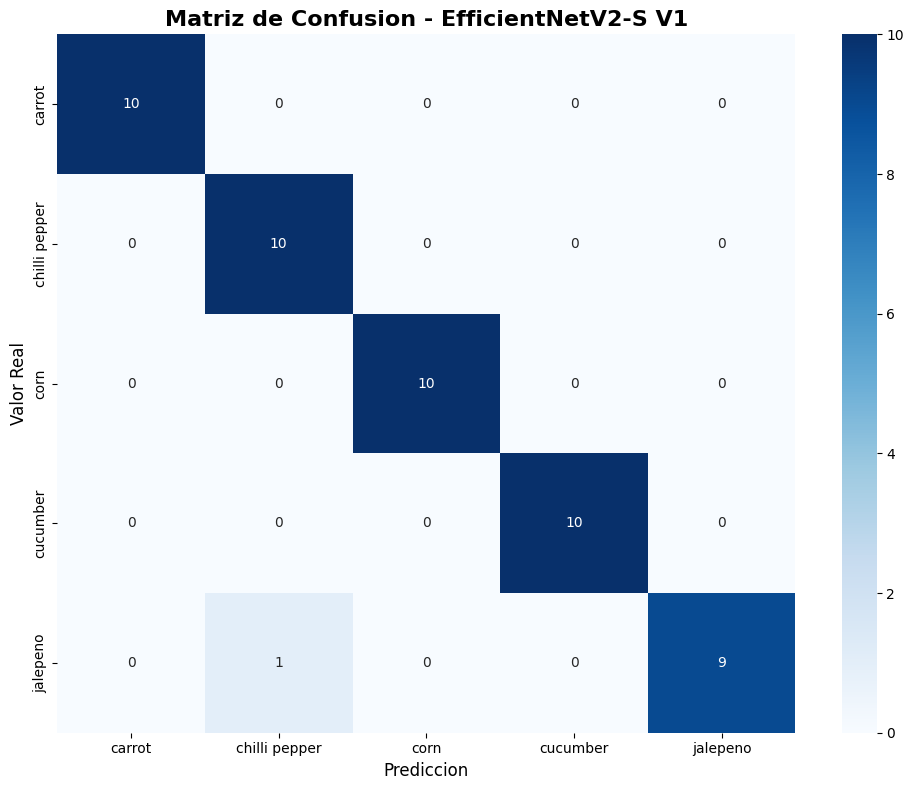


Reporte de Clasificacion:
------------------------------------------------------------
               precision    recall  f1-score   support

       carrot     1.0000    1.0000    1.0000        10
chilli pepper     0.9091    1.0000    0.9524        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10
     jalepeno     1.0000    0.9000    0.9474        10

     accuracy                         0.9800        50
    macro avg     0.9818    0.9800    0.9799        50
 weighted avg     0.9818    0.9800    0.9799        50


Accuracy V2 Sin BatchNorm/Dropout: 0.9800


In [8]:
# Evaluate Model V2 Without BatchNorm/Dropout
print("=" * 60)
print("EVALUACIÓN MODELO V2 SIN BatchNorm/Dropout")
print("=" * 60)

# Evaluar el modelo usando las funciones de utilidad (corregido: agregar class_names)
accuracy_sin, y_true_sin, y_pred_sin = evaluate_model(
    model=model_v2_sin,  
    test_loader=test_loader,
    class_names=class_names,  # Agregar class_names como parámetro
    device=device
)

print(f"\nAccuracy V2 Sin BatchNorm/Dropout: {accuracy_sin:.4f}")

## Evaluación Modelo V2 - Con BatchNorm/Dropout

**Evaluación en conjunto de prueba:**
- **Dataset**: Test set (datos no vistos durante entrenamiento)
- **Métricas**: Accuracy, Precision, Recall por clase
- **Visualizaciones**: Matriz de confusión con heatmap
- **Análisis**: Classification report detallado

**Objetivo:** Medir el rendimiento real del modelo con regularización y comparar con el modelo base.

EVALUACIÓN MODELO V2 CON BatchNorm/Dropout
Evaluando modelo en conjunto de test...

Resultados de evaluacion:
Accuracy total: 1.0000 (100.00%)
Muestras correctas: 50/50


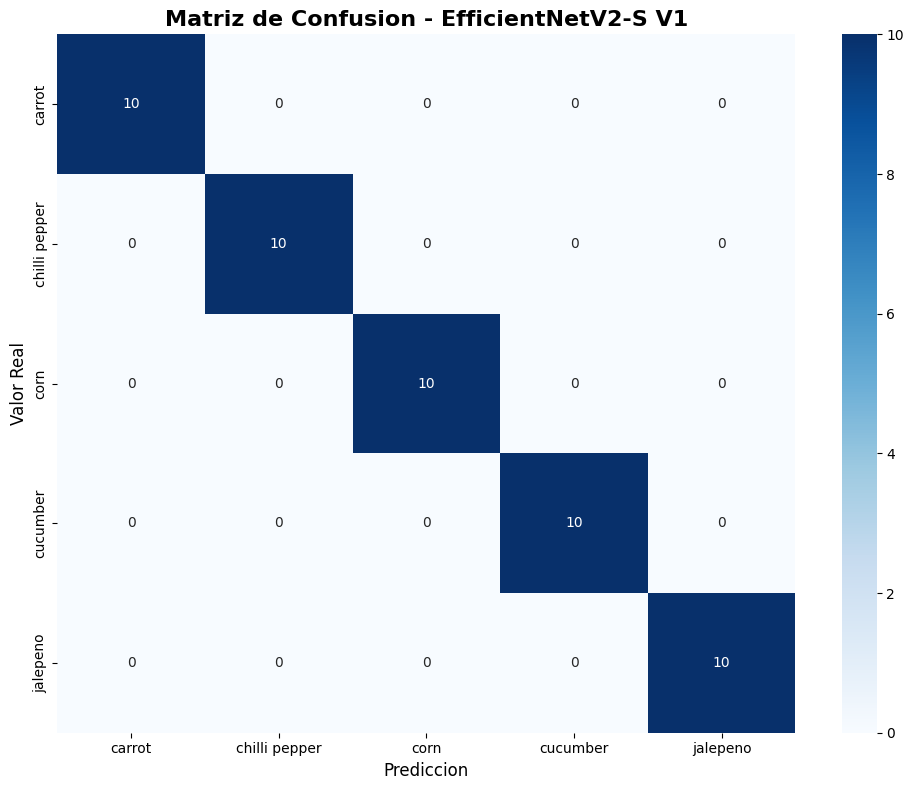


Reporte de Clasificacion:
------------------------------------------------------------
               precision    recall  f1-score   support

       carrot     1.0000    1.0000    1.0000        10
chilli pepper     1.0000    1.0000    1.0000        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10
     jalepeno     1.0000    1.0000    1.0000        10

     accuracy                         1.0000        50
    macro avg     1.0000    1.0000    1.0000        50
 weighted avg     1.0000    1.0000    1.0000        50


Accuracy V2 Con BatchNorm/Dropout: 1.0000


In [9]:
# Evaluate Model V2 With BatchNorm/Dropout
print("=" * 60)
print("EVALUACIÓN MODELO V2 CON BatchNorm/Dropout")
print("=" * 60)

# Evaluar el modelo usando las funciones de utilidad (corregido: agregar class_names)
accuracy_con, y_true_con, y_pred_con = evaluate_model(
    model=model_v2_con,
    test_loader=test_loader,
    class_names=class_names,  # Agregar class_names como parámetro
    device=device
)

print(f"\nAccuracy V2 Con BatchNorm/Dropout: {accuracy_con:.4f}")

## Comparación de Curvas de Entrenamiento

**Análisis de curvas de pérdida y accuracy:**

**Para cada modelo se visualiza:**
- Curva de pérdida de entrenamiento vs validación
- Curva de accuracy de entrenamiento vs validación
- Marcador de la mejor época (best_epoch)
- Indicadores de overfitting o underfitting

**Métricas clave a comparar:**
- Velocidad de convergencia
- Estabilidad durante el entrenamiento
- Gap entre train/validation (indicador de overfitting)
- Valor final de las métricas


Visualizando métricas V2 SIN BatchNorm/Dropout:


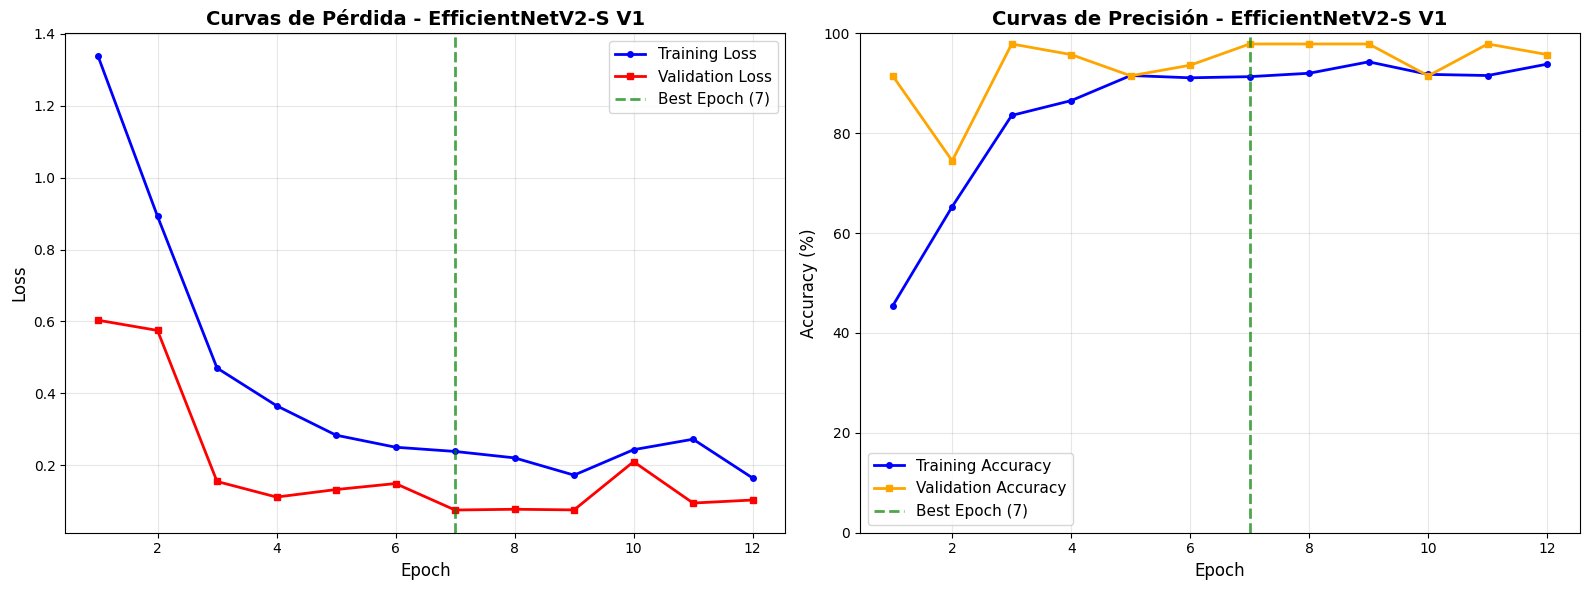

RESUMEN DE MÉTRICAS:
LOSS:
  • Final training loss:     0.1649
  • Final validation loss:   0.1036
  • Best validation loss:    0.0758 (epoch 7)
ACCURACY:
  • Final training accuracy:     93.84%
  • Final validation accuracy:   95.74%
  • Best validation accuracy:    97.87% (epoch 3)
MEJOR MODELO (Epoch 7):
  • Validation loss:     0.0758
  • Validation accuracy: 97.87%


In [10]:
# Visualizar curvas de entrenamiento V2 Sin BatchNorm/Dropout
print("\nVisualizando métricas V2 SIN BatchNorm/Dropout:")
plot_training_metrics(
    train_losses_v2_sin, 
    val_losses_v2_sin, 
    train_accuracies_v2_sin, 
    val_accuracies_v2_sin, 
    best_epoch_v2_sin
)


Visualizando métricas V2 CON BatchNorm/Dropout:


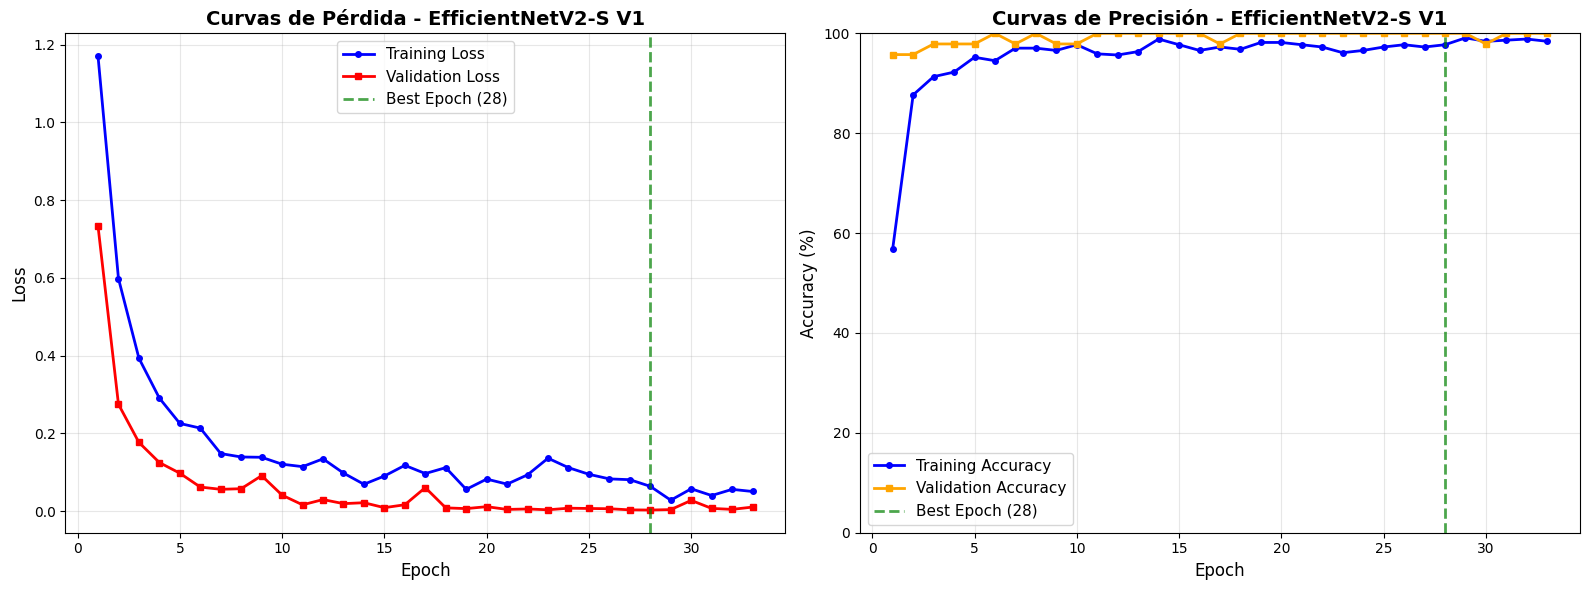

RESUMEN DE MÉTRICAS:
LOSS:
  • Final training loss:     0.0507
  • Final validation loss:   0.0107
  • Best validation loss:    0.0031 (epoch 28)
ACCURACY:
  • Final training accuracy:     98.40%
  • Final validation accuracy:   100.00%
  • Best validation accuracy:    100.00% (epoch 6)
MEJOR MODELO (Epoch 28):
  • Validation loss:     0.0031
  • Validation accuracy: 100.00%


In [11]:
# Visualizar curvas de entrenamiento V2 Con BatchNorm/Dropout
print("\nVisualizando métricas V2 CON BatchNorm/Dropout:")
plot_training_metrics(
    train_losses_v2_con, 
    val_losses_v2_con, 
    train_accuracies_v2_con, 
    val_accuracies_v2_con, 
    best_epoch_v2_con
)

In [12]:
# Resumen de Resultados - Versión 2: Clasificador Tipo Embudo
print("=" * 70)
print("RESUMEN DE RESULTADOS - VERSIÓN 2")
print("=" * 70)

print("\nEXPERIMENTO REALIZADO:")
print("-" * 50)
print("• Arquitectura: ResNet18 + Clasificador tipo embudo")
print("• Estructura: 512 → 256 → 128 → num_classes")
print("• Transfer Learning: Features congeladas")
print("• Dos variantes entrenadas con mismos parámetros")

print("\nCONFIGURACIÓN DE ENTRENAMIENTO:")
print("-" * 50)
print(f"• Optimizador: Adam (lr={learning_rate})")
print(f"• Early stopping: {patience} épocas")
print(f"• Batch size: {batch_size}")
print(f"• Dataset: {num_classes} clases, {len(train_dataset)} muestras entrenamiento")

print("\nRESULTADOS OBTENIDOS:")
print("-" * 50)

print("MODELO SIN BatchNorm/Dropout:")
print(f"   • Test Accuracy: {accuracy_sin:.4f} ({accuracy_sin*100:.1f}%)")
print(f"   • Mejor época: {best_epoch_v2_sin}")
print(f"   • Total épocas: {len(train_losses_v2_sin)}")
print(f"   • Loss final train: {train_losses_v2_sin[-1]:.4f}")
print(f"   • Loss final val: {val_losses_v2_sin[-1]:.4f}")
print(f"   • Accuracy final train: {train_accuracies_v2_sin[-1]:.1f}%")
print(f"   • Accuracy final val: {val_accuracies_v2_sin[-1]:.1f}%")

print("\nMODELO CON BatchNorm/Dropout:")
print(f"   • Test Accuracy: {accuracy_con:.4f} ({accuracy_con*100:.1f}%)")
print(f"   • Mejor época: {best_epoch_v2_con}")
print(f"   • Total épocas: {len(train_losses_v2_con)}")
print(f"   • Loss final train: {train_losses_v2_con[-1]:.4f}")
print(f"   • Loss final val: {val_losses_v2_con[-1]:.4f}")
print(f"   • Accuracy final train: {train_accuracies_v2_con[-1]:.1f}%")
print(f"   • Accuracy final val: {val_accuracies_v2_con[-1]:.1f}%")

print("\nANÁLISIS DE COMPORTAMIENTO:")
print("-" * 50)

# Gap entre train y validation
gap_sin = train_accuracies_v2_sin[-1] - val_accuracies_v2_sin[-1]
gap_con = train_accuracies_v2_con[-1] - val_accuracies_v2_con[-1]

print(f"• Gap Train-Validation Sin BN/Dropout: {gap_sin:.1f}%")
print(f"• Gap Train-Validation Con BN/Dropout: {gap_con:.1f}%")

# Diferencia de accuracy
diff_accuracy = accuracy_con - accuracy_sin
if diff_accuracy > 0:
    print(f"• Modelo con regularización fue {diff_accuracy:.3f} puntos mejor")
else:
    print(f"• Modelo sin regularización fue {abs(diff_accuracy):.3f} puntos mejor")

# Convergencia
diff_epochs = best_epoch_v2_con - best_epoch_v2_sin
if diff_epochs < 0:
    print(f"• Modelo con regularización convergió {abs(diff_epochs)} épocas más rápido")
else:
    print(f"• Modelo sin regularización convergió {diff_epochs} épocas más rápido")

print("\nMÉTRICAS GENERADAS:")
print("-" * 50)
print("• Matrices de confusión para ambos modelos")
print("• Classification reports (Precision, Recall, F1)")
print("• Curvas de pérdida durante entrenamiento")
print("• Curvas de accuracy durante entrenamiento")
print("• Evaluación en conjunto de prueba independiente")

print("\nOBSERVACIONES:")
print("-" * 50)

# Determinar si hubo early stopping
if len(train_losses_v2_sin) < num_epochs:
    print(f"• Modelo sin regularización: Early stopping en época {len(train_losses_v2_sin)}")
else:
    print("• Modelo sin regularización: Entrenó todas las épocas")

if len(train_losses_v2_con) < num_epochs:
    print(f"• Modelo con regularización: Early stopping en época {len(train_losses_v2_con)}")
else:
    print("• Modelo con regularización: Entrenó todas las épocas")

# Análisis de overfitting
if abs(gap_con) < abs(gap_sin):
    print("• Regularización redujo el overfitting")
else:
    print("• Regularización no redujo el overfitting significativamente")

print("\nCUMPLIMIENTO DE OBJETIVOS:")
print("-" * 50)
print("Arquitectura tipo embudo implementada correctamente")
print("Dos entrenamientos realizados (con y sin regularización)")
print("Early stopping aplicado exitosamente")
print("Métricas completas de evaluación obtenidas")
print("Comparación de técnicas de regularización completada")

print("\n" + "=" * 70)
print("RESUMEN COMPLETADO")
print("=" * 70)

RESUMEN DE RESULTADOS - VERSIÓN 2

EXPERIMENTO REALIZADO:
--------------------------------------------------
• Arquitectura: ResNet18 + Clasificador tipo embudo
• Estructura: 512 → 256 → 128 → num_classes
• Transfer Learning: Features congeladas
• Dos variantes entrenadas con mismos parámetros

CONFIGURACIÓN DE ENTRENAMIENTO:
--------------------------------------------------
• Optimizador: Adam (lr=0.001)
• Early stopping: 5 épocas
• Batch size: 32
• Dataset: 5 clases, 438 muestras entrenamiento

RESULTADOS OBTENIDOS:
--------------------------------------------------
MODELO SIN BatchNorm/Dropout:
   • Test Accuracy: 0.9800 (98.0%)
   • Mejor época: 7
   • Total épocas: 12
   • Loss final train: 0.1649
   • Loss final val: 0.1036
   • Accuracy final train: 93.8%
   • Accuracy final val: 95.7%

MODELO CON BatchNorm/Dropout:
   • Test Accuracy: 1.0000 (100.0%)
   • Mejor época: 28
   • Total épocas: 33
   • Loss final train: 0.0507
   • Loss final val: 0.0107
   • Accuracy final train: 